In [1]:
import pandas as pd
import numpy as np
from tqdm import tqdm
from itertools import combinations
import matplotlib.pyplot as plt

In [2]:
data_path = 'data/'
train = pd.read_csv(data_path+'sensor_train.csv')
test = pd.read_csv(data_path+'sensor_test.csv')

In [7]:
y_train = train.groupby('fragment_id')['behavior_id'].min()
pd.Series(y_train).value_counts()

6     742
12    734
1     676
15    478
11    449
4     435
2     409
16    345
18    345
5     343
3     332
8     328
13    291
9     287
17    259
0     241
10    236
7     236
14    126
Name: behavior_id, dtype: int64

## 数据分析

In [3]:
train.head()

,fragment_id,time_point,acc_x,acc_y,acc_z,acc_xg,acc_yg,acc_zg,behavior_id
0,0,27,0.3,-0.3,0.1,0.6,4.5,8.8,0
1,0,108,0.1,-0.0,-0.4,0.4,4.7,8.4,0
2,0,198,0.1,0.0,0.3,0.9,4.6,9.0,0
3,0,297,0.1,-0.1,-0.5,0.8,4.7,7.2,0
4,0,388,0.1,0.2,0.6,0.9,4.7,8.9,0


In [4]:
train.describe()

,fragment_id,time_point,acc_x,acc_y,acc_z,acc_xg,acc_yg,acc_zg,behavior_id
count,425359.000000,425359.000000,425359.000000,425359.000000,425359.000000,425359.000000,425359.000000,425359.000000,425359.000000
mean,3647.035972,2500.952026,0.009635,-0.063114,0.024548,0.965656,2.730190,7.825065,8.535035
std,2103.253140,1442.307956,0.619285,0.537614,0.717009,3.295531,2.978134,2.653261,5.395264
min,0.000000,0.000000,-14.700000,-14.700000,-12.600000,-19.800000,-16.900000,-8.900000,0.000000
25%,1822.000000,1252.000000,-0.100000,-0.100000,-0.200000,-0.700000,0.400000,7.300000,4.000000
50%,3646.000000,2501.000000,0.000000,0.000000,0.000000,0.200000,2.700000,8.700000,8.000000
75%,5466.000000,3749.000000,0.100000,0.100000,0.200000,2.000000,4.900000,9.400000,13.000000
max,7291.000000,4999.000000,34.500000,13.400000,28.200000,30.200000,14.400000,38.100000,18.000000


In [5]:
def statics(data):
    stats = []
    for col in data.columns:
        stats.append((col, data[col].nunique(), data[col].isnull().sum() * 100 / data.shape[0],
                      data[col].value_counts(normalize=True, dropna=False).values[0] * 100, data[col].dtype))

    stats_df = pd.DataFrame(stats, columns=['Feature', 'Unique_values', 'Percentage_of_missing_values',
                                            'Percentage_of_values_in_the_biggest category', 'type'])
    stats_df.sort_values('Percentage_of_missing_values', ascending=False, inplace=True)
    return stats_df

In [6]:
train_stats_df=statics(train)
train_stats_df

,Feature,Unique_values,Percentage_of_missing_values,Percentage_of_values_in_the_biggest category,type
0,fragment_id,7292,0.0,0.014341,int64
1,time_point,5000,0.0,0.033148,int64
2,acc_x,212,0.0,27.568948,float64
3,acc_y,159,0.0,34.423393,float64
4,acc_z,218,0.0,19.457447,float64
5,acc_xg,300,0.0,3.593905,float64
6,acc_yg,272,0.0,2.087648,float64
7,acc_zg,284,0.0,4.472457,float64
8,behavior_id,19,0.0,10.260980,int64


In [9]:
train.columns

Index(['fragment_id', 'time_point', 'acc_x', 'acc_y', 'acc_z', 'acc_xg',
       'acc_yg', 'acc_zg', 'behavior_id'],
      dtype='object')

## 时间序列画图

In [14]:
# def plot_activity(activity, df):
#     data = df[df['behavior_id'] == activity][['acc_x', 'acc_y', 'acc_z']][:60]
#     axis = data["acc_x"].plot(subplots=True, 
#                      title=activity,color="b")
#     axis = data["acc_y"].plot(subplots=True, 
#                  title=activity,color="r")
#     axis = data["acc_z"].plot(subplots=True, 
#              title=activity,color="g")
#     for ax in axis:
#         ax.legend(loc='lower left', bbox_to_anchor=(1.0, 0.5))

In [75]:
def plot_activity(activity, df):
    df=df[df['behavior_id'] == activity]
    for index,(fragment_id,tmp) in enumerate(df.groupby(by='fragment_id')):
        fig=plt.figure()
        data = tmp[['acc_x', 'acc_y', 'acc_z']][:60]
#         print(tmp)
        axis = data["acc_x"].plot(subplots=True, 
                             title=activity,color="b")
        axis = data["acc_y"].plot(subplots=True, 
                         title=activity,color="r")
        axis = data["acc_z"].plot(subplots=True, 
                     title=activity,color="g")
        for ax in axis:
            ax.legend(loc='lower left', bbox_to_anchor=(1.0, 0.5))
        plt.plot()
        if index==10:
            break


##  类别 0

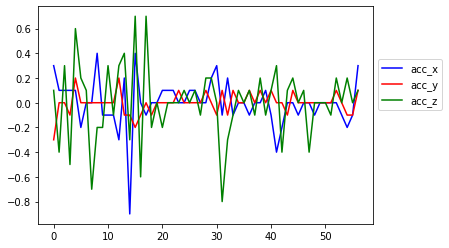

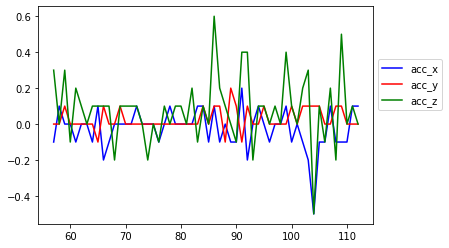

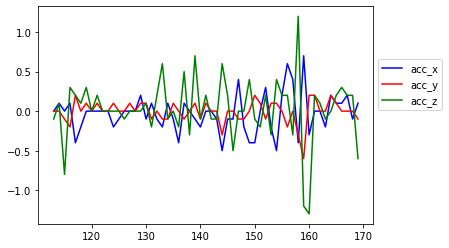

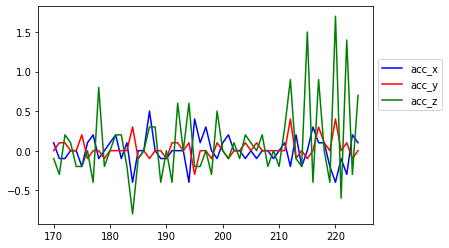

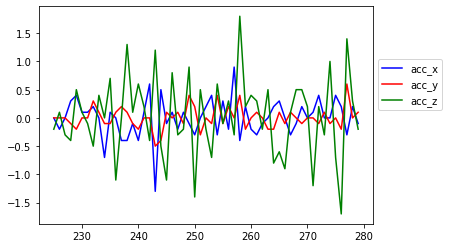

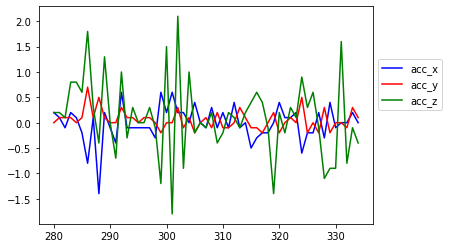

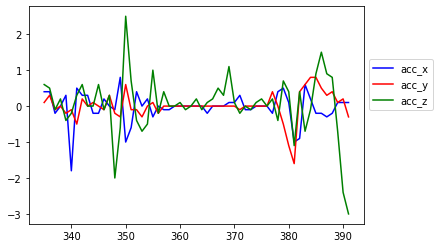

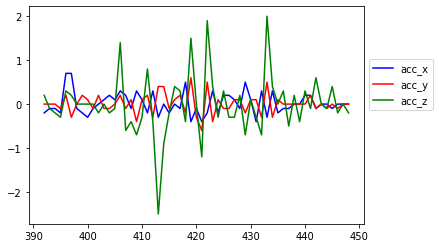

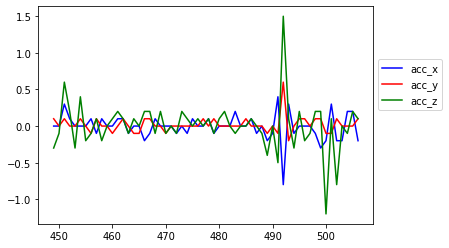

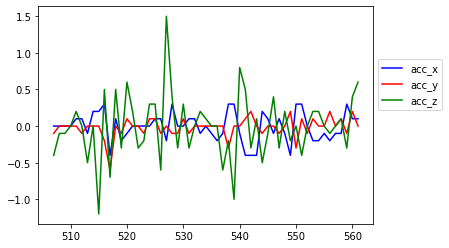

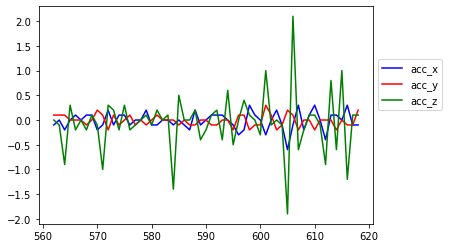

In [76]:
plot_activity(0, train)

## 类别1

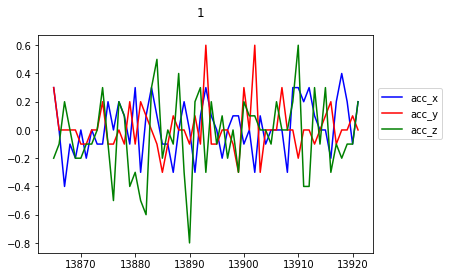

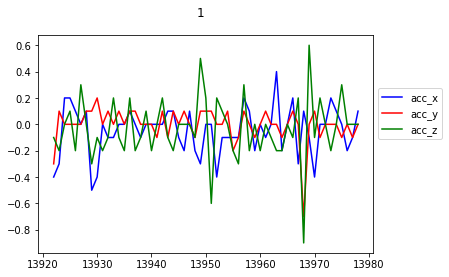

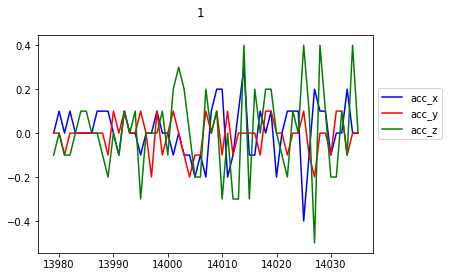

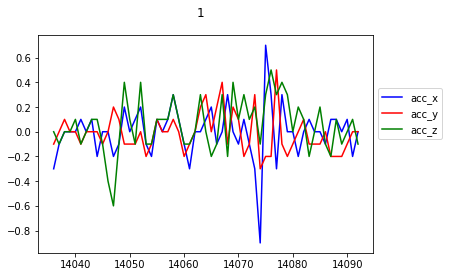

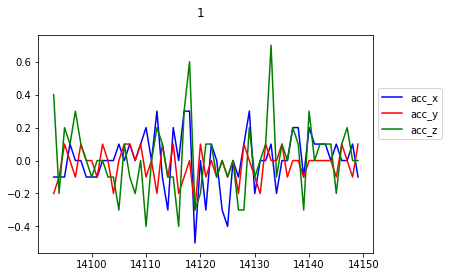

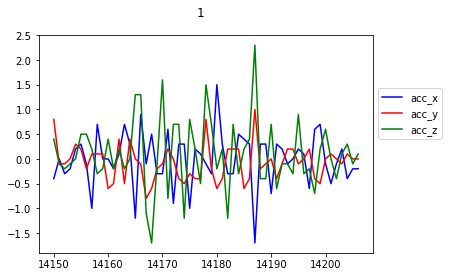

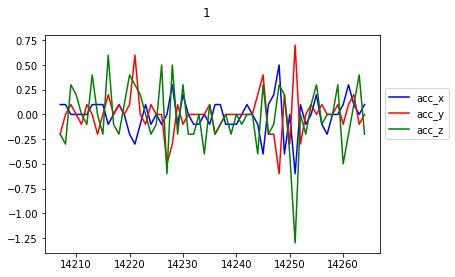

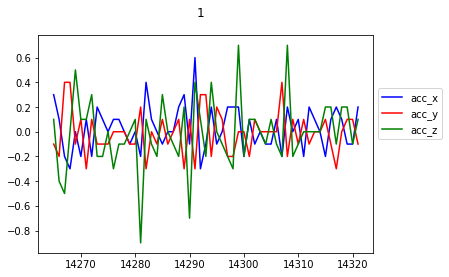

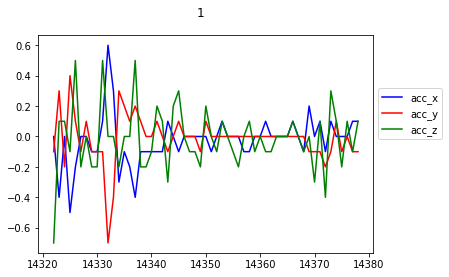

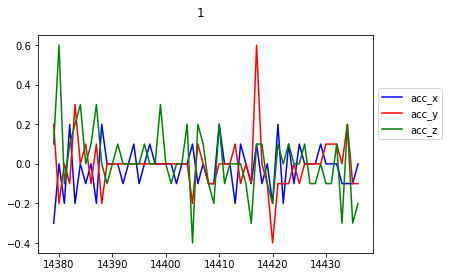

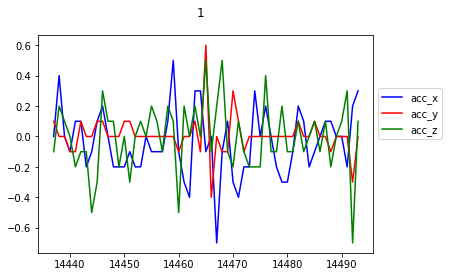

In [77]:
plot_activity(1, train)

## 类别2

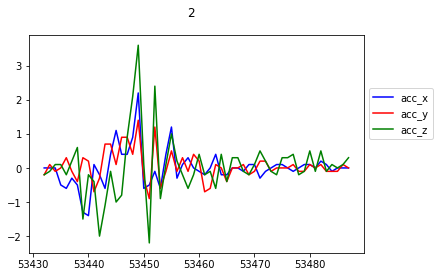

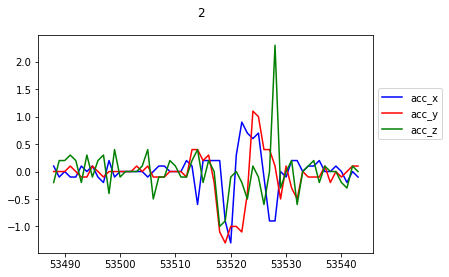

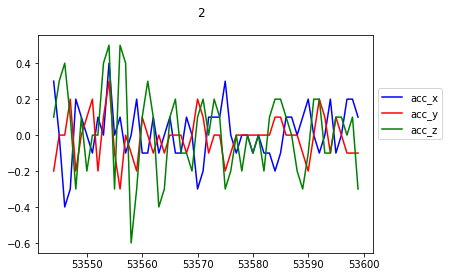

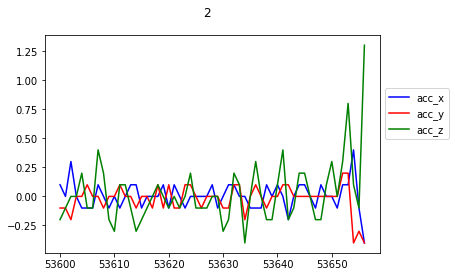

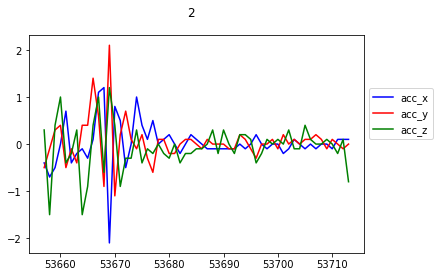

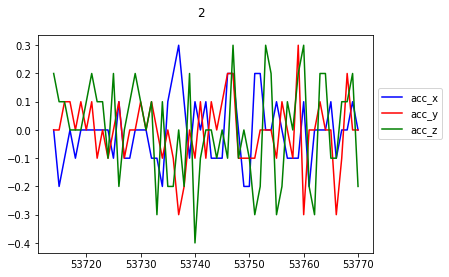

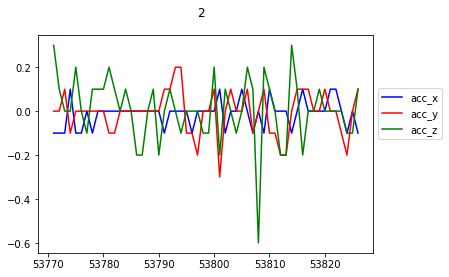

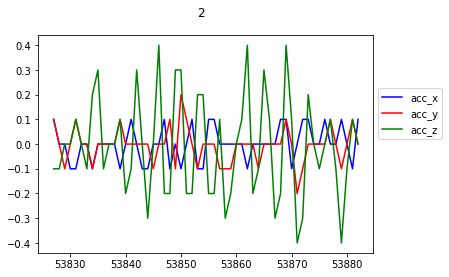

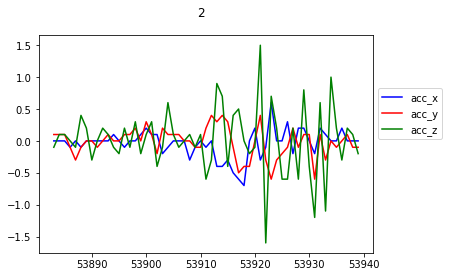

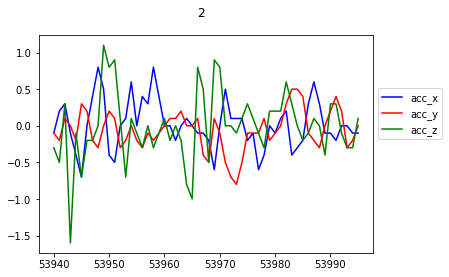

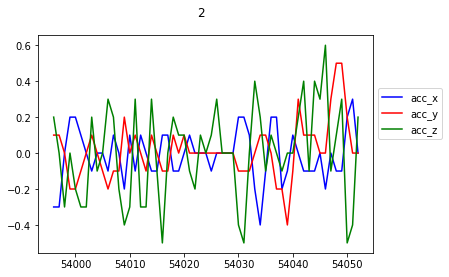

In [78]:
plot_activity(2, train)

## 类别3

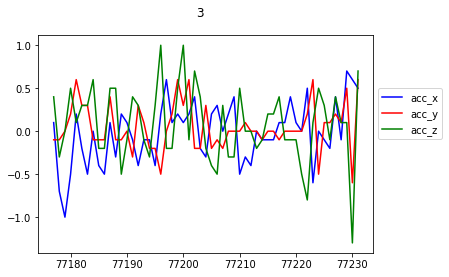

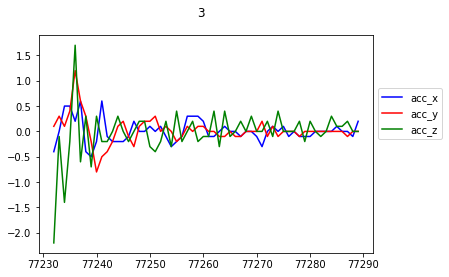

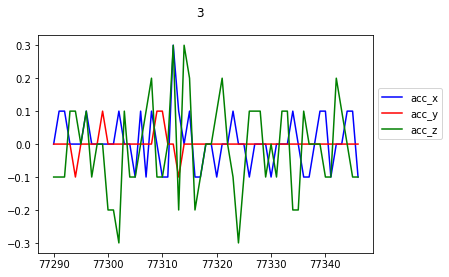

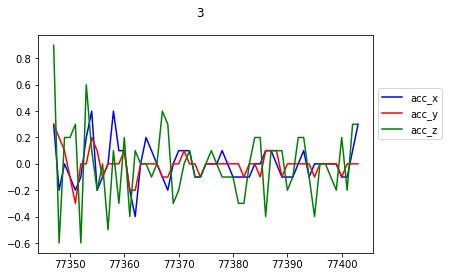

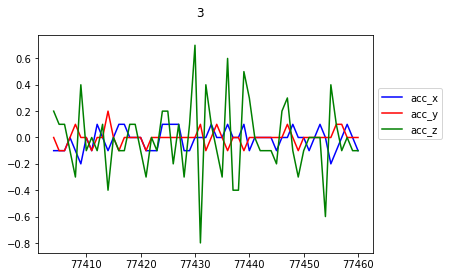

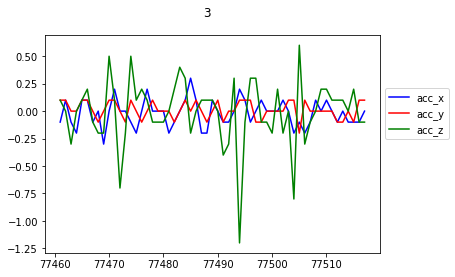

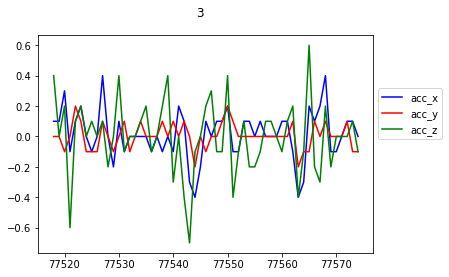

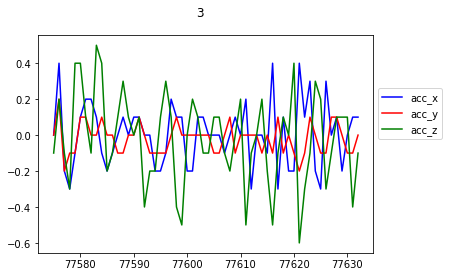

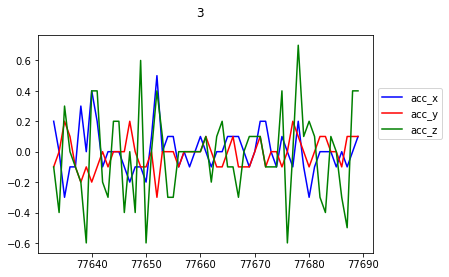

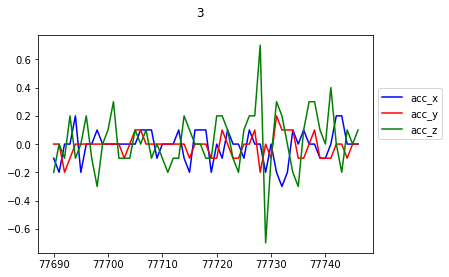

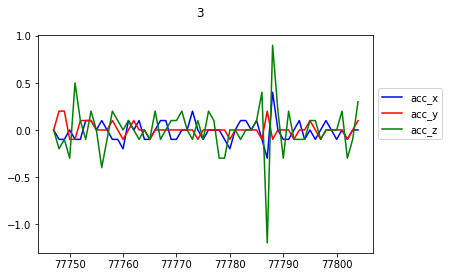

In [79]:
plot_activity(3, train)

## 类别4

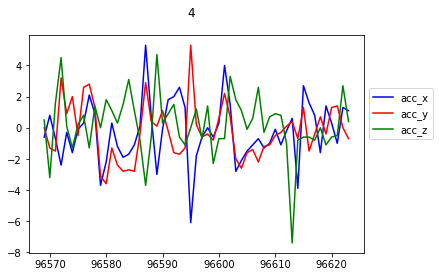

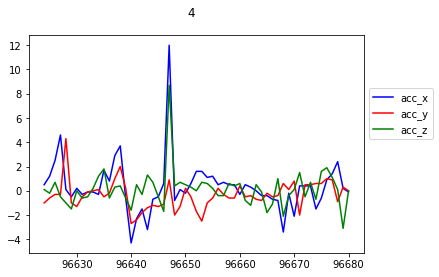

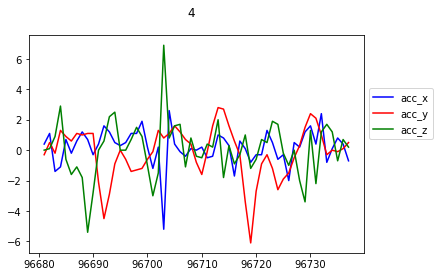

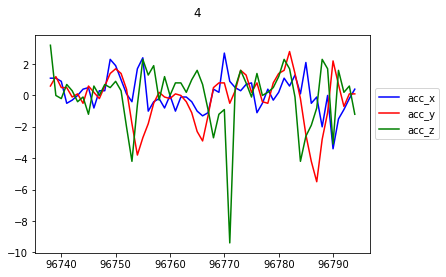

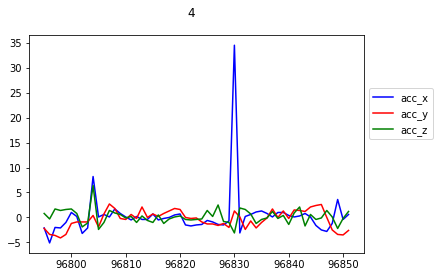

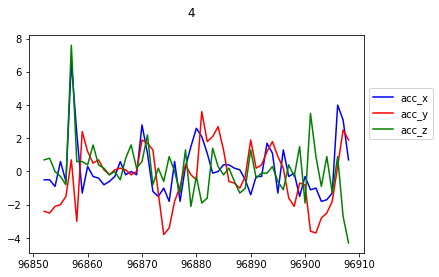

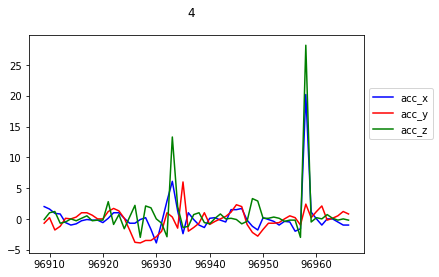

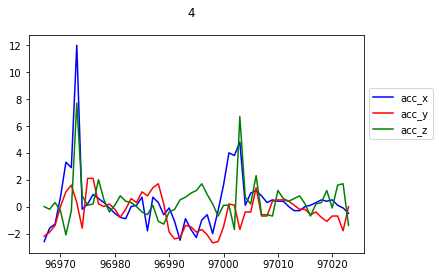

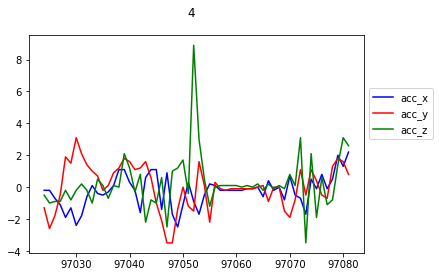

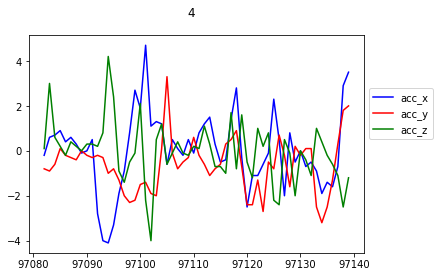

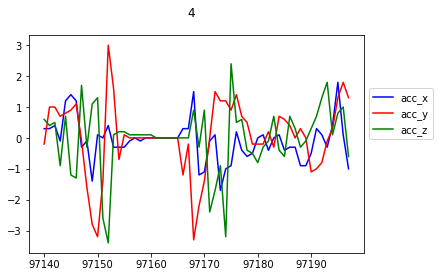

In [80]:
plot_activity(4, train)

## 类别5

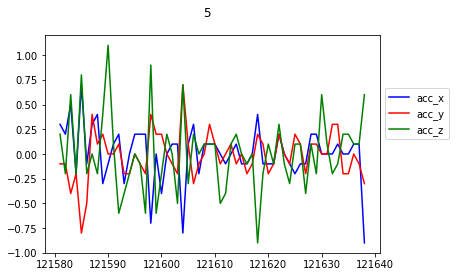

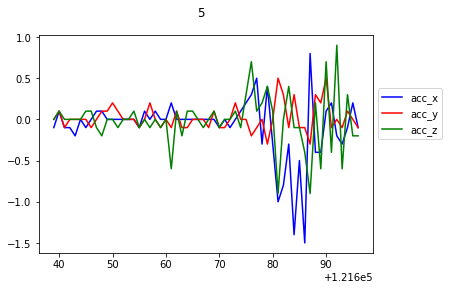

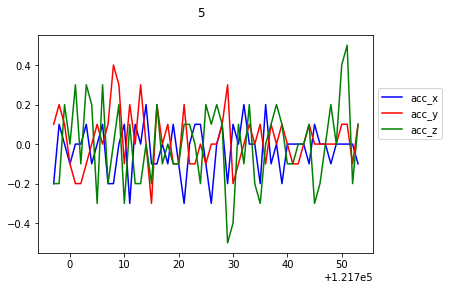

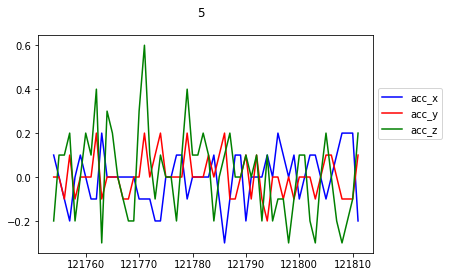

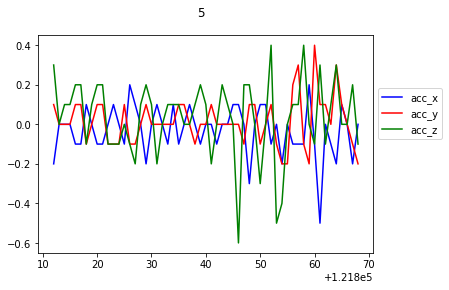

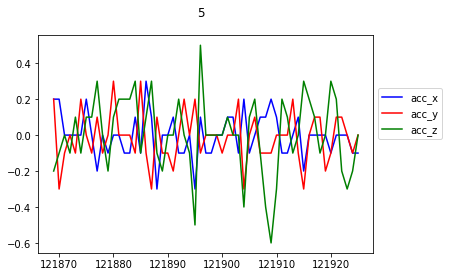

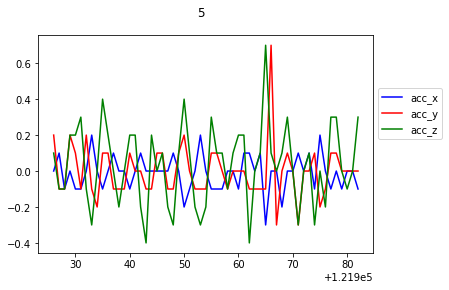

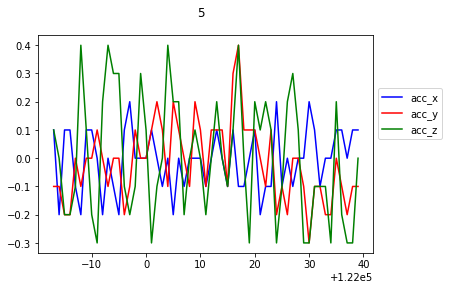

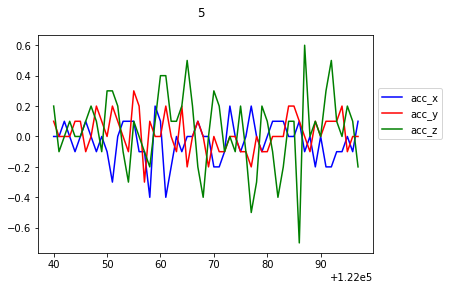

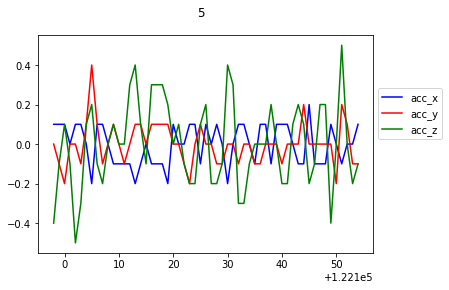

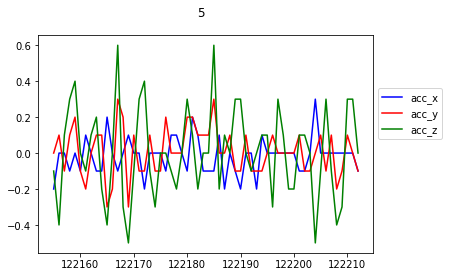

In [81]:
plot_activity(5, train)

## 类别6

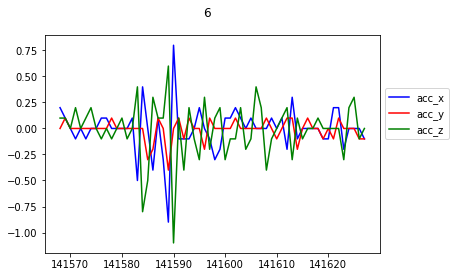

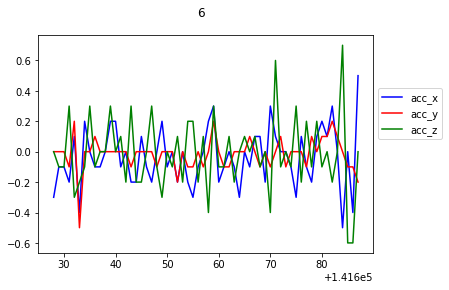

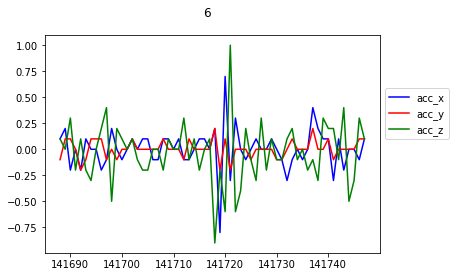

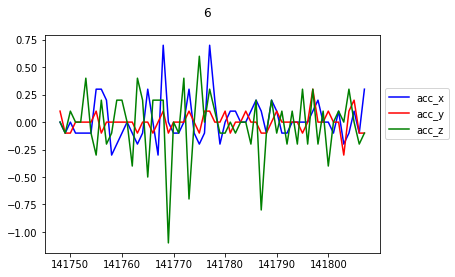

In [64]:
plot_activity(6, train)

## 类别7

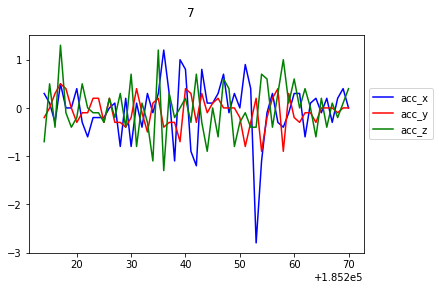

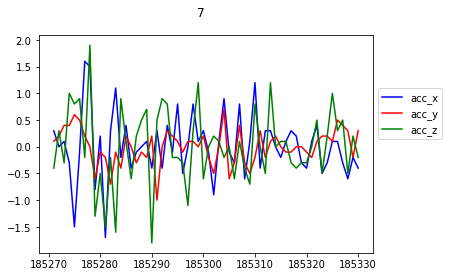

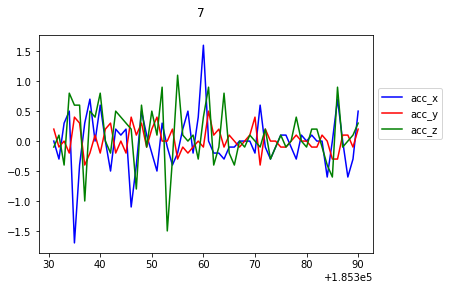

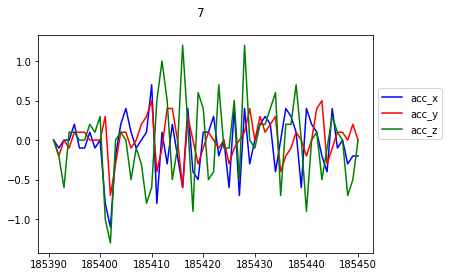

In [65]:
plot_activity(7, train)

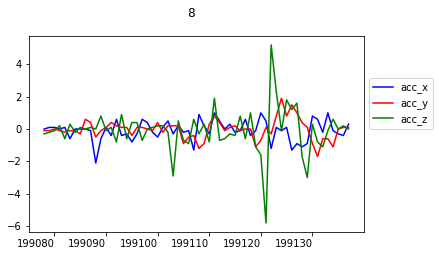

In [23]:
plot_activity(8, train)

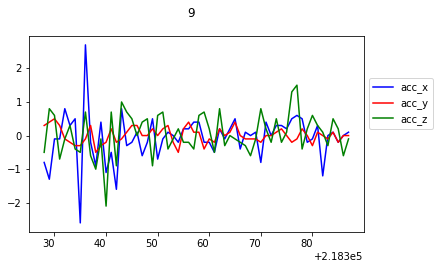

In [24]:
plot_activity(9, train)

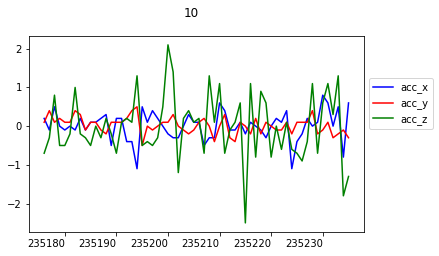

In [25]:
plot_activity(10, train)

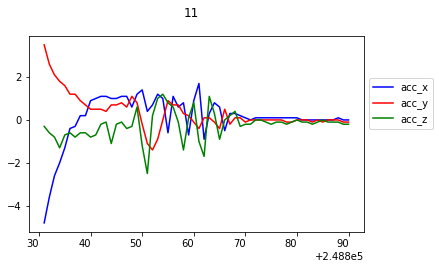

In [26]:
plot_activity(11, train)

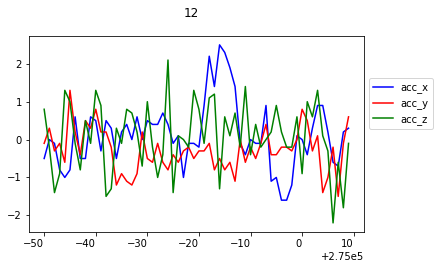

In [27]:
plot_activity(12, train)

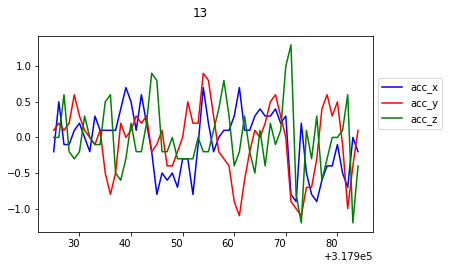

In [28]:
plot_activity(13, train)

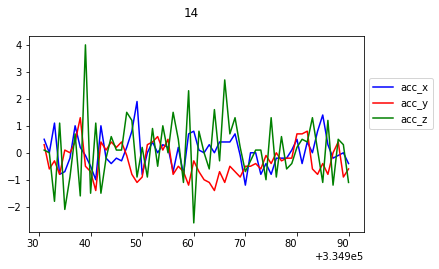

In [29]:
plot_activity(14, train)

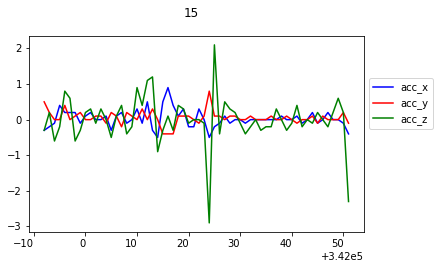

In [30]:
plot_activity(15, train)

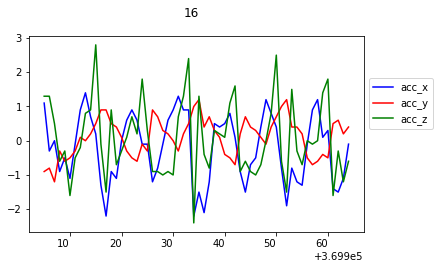

In [31]:
plot_activity(16, train)

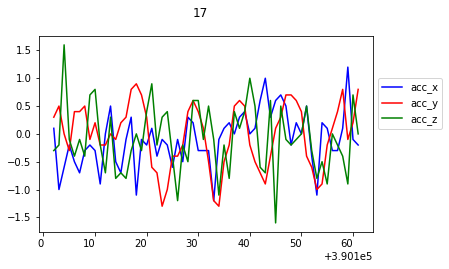

In [32]:
plot_activity(17, train)

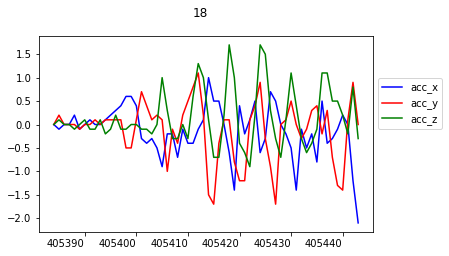

In [33]:
plot_activity(18, train)